# 📗 AgriVision Data Wrangling & Feature Engineering

This notebook demonstrates a professional **ML data preparation workflow** for integrating and cleaning 
multi-source plant trait datasets. It simulates PySpark-style transformations using Pandas for 
a scalable agricultural analytics pipeline.

---

**Author:** Mukaram Ali  
**GitHub:** [github.com/mukaram163/AgriVision](https://github.com/mukaram163/AgriVision)  
**LinkedIn:** [linkedin.com/in/mukaram-ali-a05061279](https://linkedin.com/in/mukaram-ali-a05061279)

In [1]:
# 🧩 Environment Setup

# Core libraries
import os
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display preferences for cleaner outputs
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# Suppress unnecessary warnings for readability
import warnings
warnings.filterwarnings("ignore")

In production ML pipelines, **Pandas** is typically used for local data exploration and prototyping,  
while **PySpark** or **Dask** handle large-scale distributed wrangling.  

Here, we simulate a **Spark-style transformation workflow** on a smaller mock dataset using Pandas.

In [2]:
# =============================================================
# 🌾 Simulate Raw Data Sources (Traits + Labels)
# =============================================================
# Mock dataset 1: plant traits collected from sensors or field logs
plant_traits = pd.DataFrame({
    "plant_id": range(1, 11),
    "species": ["Tomato", "Tomato", "Pepper", "Potato", "Potato", 
                "Tomato", "Pepper", "Potato", "Tomato", "Tomato"],
    "height_cm": [45, 50, np.nan, 60, 58, 55, 48, 59, 53, None],
    "leaf_count": [15, 17, 13, None, 18, 14, 16, 17, 15, 19],
    "timestamp": pd.date_range("2025-06-01", periods=10, freq="D")
})

# Mock dataset 2: disease labels or target variables from annotation system
disease_labels = pd.DataFrame({
    "plant_id": range(1, 11),
    "disease_type": [
        "Late_blight", "Healthy", "Bacterial_spot", "Early_blight", "Healthy",
        "Late_blight", "Bacterial_spot", "Healthy", "Late_blight", "Healthy"
    ],
    "severity_score": [0.7, 0.1, 0.8, 0.5, 0.0, 0.6, 0.9, 0.2, 0.7, 0.0]
})

These mock datasets simulate two key sources in a plant phenotyping pipeline:

- **Plant traits** → numeric and categorical attributes collected from sensors or field records.  
- **Disease labels** → supervised targets derived from image annotations or pathology reports.  

In production, these would be ingested from APIs, IoT devices, or cloud storage (e.g., Azure Blob / GCS).

In [3]:
# =============================================================
# 🧩 Data Quality Checks & Imputation
# =============================================================

# Check for missing values
print("🔍 Missing values before cleaning:\n")
print(plant_traits.isnull().sum())

# Impute missing numeric features (avoid chained assignment warning)
plant_traits = plant_traits.assign(
    height_cm=lambda df: df["height_cm"].fillna(df["height_cm"].mean()),
    leaf_count=lambda df: df["leaf_count"].fillna(df["leaf_count"].median())
)

# Check for duplicate rows
duplicates = plant_traits.duplicated().sum()
print(f"\n🧾 Duplicates before cleaning: {duplicates}")

# Add a data integrity flag
plant_traits["is_cleaned"] = True

🔍 Missing values before cleaning:

plant_id      0
species       0
height_cm     2
leaf_count    1
timestamp     0
dtype: int64

🧾 Duplicates before cleaning: 0


Handling missing values and duplicates is a core step in any ML data pipeline.  

Here we apply simple **statistical imputation** (mean and median) to maintain dataset consistency.  
In production systems, this step would typically be handled via **KNN imputation**, **model-based filling**,  
or **domain-driven thresholds** within a scalable ETL workflow.

In [4]:
# =============================================================
# 🔗 Data Integration: Merge Traits & Labels
# =============================================================
# Ensure required dataframes exist
assert "plant_traits" in globals() and "disease_labels" in globals(), \
    "Required datasets not found. Run the data simulation cells first."

# Perform inner join on plant_id to combine traits and labels
df = pd.merge(plant_traits, disease_labels, on="plant_id", how="inner")

# Preview merged dataset
df.head()

,plant_id,species,height_cm,leaf_count,timestamp,is_cleaned,disease_type,severity_score
0,1,Tomato,45.0,15.0,2025-06-01,True,Late_blight,0.7
1,2,Tomato,50.0,17.0,2025-06-02,True,Healthy,0.1
2,3,Pepper,53.5,13.0,2025-06-03,True,Bacterial_spot,0.8
3,4,Potato,60.0,16.0,2025-06-04,True,Early_blight,0.5
4,5,Potato,58.0,18.0,2025-06-05,True,Healthy,0.0


This step simulates the **data integration phase** of a production pipeline,  
where multiple data sources are joined on a shared key (`plant_id`).  

In a distributed PySpark workflow, this would be achieved with:  
```python
df = df1.join(df2, on="plant_id", how="inner")

In [5]:
# =============================================================
# 🧠 Feature Engineering
# =============================================================
# Derived biological and temporal features for model training
df = df.assign(
    leaf_density = (df["leaf_count"] / df["height_cm"]).round(2),
    is_diseased  = (df["disease_type"] != "Healthy").astype(int),
    month        = df["timestamp"].dt.month
)

# Preview engineered features
df.head()

,plant_id,species,height_cm,leaf_count,timestamp,is_cleaned,disease_type,severity_score,leaf_density,is_diseased,month
0,1,Tomato,45.0,15.0,2025-06-01,True,Late_blight,0.7,0.33,1,6
1,2,Tomato,50.0,17.0,2025-06-02,True,Healthy,0.1,0.34,0,6
2,3,Pepper,53.5,13.0,2025-06-03,True,Bacterial_spot,0.8,0.24,1,6
3,4,Potato,60.0,16.0,2025-06-04,True,Early_blight,0.5,0.27,1,6
4,5,Potato,58.0,18.0,2025-06-05,True,Healthy,0.0,0.31,0,6


Feature engineering converts raw measurements into **model-ready variables**.  
Here we derive biologically meaningful and time-aware features:

- **`leaf_density`** → morphological indicator (leafs per cm of height).  
- **`is_diseased`** → binary classification target for supervised models.  
- **`month`** → captures potential seasonal or environmental variation.  

These features enhance model interpretability and predictive power.

In [6]:
# =============================================================
# ⚙️ PySpark-Style Transformation (Mocked with Pandas)
# =============================================================
# Simulate a distributed data transformation workflow using Pandas chaining
df_spark_mock = (
    df
    .assign(
        severity_bucket=lambda d: pd.cut(
            d["severity_score"],
            bins=[-0.1, 0.3, 0.7, 1.0],
            labels=["Low", "Medium", "High"]
        )
    )
    .query("height_cm > 50")                  # Filter step
    .sort_values(by="severity_score", ascending=False)  # Sort by severity
    .reset_index(drop=True)                   # Re-index for clean output
)

# Preview transformed dataframe
df_spark_mock.head()

,plant_id,species,height_cm,leaf_count,timestamp,is_cleaned,disease_type,severity_score,leaf_density,is_diseased,month,severity_bucket
0,3,Pepper,53.5,13.0,2025-06-03,True,Bacterial_spot,0.8,0.24,1,6,High
1,9,Tomato,53.0,15.0,2025-06-09,True,Late_blight,0.7,0.28,1,6,Medium
2,6,Tomato,55.0,14.0,2025-06-06,True,Late_blight,0.6,0.25,1,6,Medium
3,4,Potato,60.0,16.0,2025-06-04,True,Early_blight,0.5,0.27,1,6,Medium
4,8,Potato,59.0,17.0,2025-06-08,True,Healthy,0.2,0.29,0,6,Low


This section emulates a **PySpark-style chained transformation** using Pandas syntax.  

Each operation represents a common step in distributed ETL pipelines:  
- **`assign()`** → feature creation or bucketization  
- **`query()`** → row-level filtering  
- **`sort_values()`** → ordering for downstream analytics  
- **`reset_index()`** → clean re-indexing after transformations  

This functional chaining pattern mirrors the **lazy, declarative style** of PySpark DataFrame APIs,  
enabling modular and reproducible data pipelines.

,disease_type,height_cm,leaf_density,severity_score
0,Bacterial_spot,53.500,0.240,0.800
1,Early_blight,60.000,0.270,0.500
2,Healthy,56.833,0.320,0.067
3,Late_blight,54.000,0.265,0.650


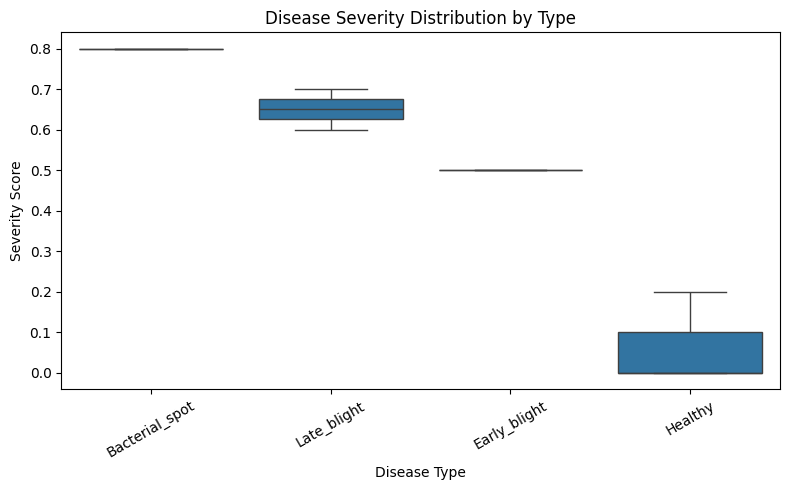

In [7]:
# =============================================================
# 📊 Summary Statistics by Disease Type
# =============================================================
# Compute mean trait and severity metrics for each disease category
agg_summary = (
    df_spark_mock
    .groupby("disease_type", as_index=False)
    .agg({
        "height_cm": "mean",
        "leaf_density": "mean",
        "severity_score": "mean"
    })
    .round(3)
)

display(agg_summary)

# =============================================================
# 🎨 Visualization: Disease Severity Distribution
# =============================================================
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_spark_mock,
    x="disease_type",
    y="severity_score"
)
plt.title("Disease Severity Distribution by Type", fontsize=12)
plt.xlabel("Disease Type")
plt.ylabel("Severity Score")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Visual and statistical summaries are essential for **exploratory data validation**.  

- The aggregation highlights **trait and severity averages** per disease type,  
  supporting hypothesis checks (e.g., whether certain infections correlate with lower plant height).  
- The boxplot reveals **distributional variance and potential outliers**,  
  informing later steps like **feature scaling**, **normalization**, or **model weighting**.  

In production pipelines, such diagnostics would be logged or visualized automatically via dashboards (e.g., MLflow, DataDog, or Power BI).

In [8]:
# =============================================================
# 💾 Export Processed Dataset
# =============================================================
# Define output directory and file path
output_dir = "../data/processed"
output_path = os.path.join(output_dir, "cleaned_traits.csv")

# Ensure directory exists and export processed data
os.makedirs(output_dir, exist_ok=True)
df_spark_mock.to_csv(output_path, index=False)

print(f"✅ Cleaned dataset successfully saved to: {output_path}")

✅ Cleaned dataset successfully saved to: ../data/processed/cleaned_traits.csv


Exporting the processed dataset ensures **reproducibility** and establishes **data lineage**,  
allowing downstream ML pipelines to access consistent, versioned inputs.  

In production, this step would typically be handled via:
- **Automated ETL jobs** (Airflow, Prefect, or Kubeflow)
- **Cloud storage pipelines** (Azure Data Lake, GCS, or S3)
- **Data catalog integration** (to track schema and provenance)

This marks the dataset as **ready for model training and deployment pipelines**.